In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from copy import deepcopy
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from scipy.stats import t




In [8]:
def read_in_and_process_data(file_path, savgol_window=61, toggle_plot=False):
    """
    This function reads in the data from the given file path, smooths it using Savitzky-Golay filter,
    plots the raw and denoised signal of sensor 1 of the Turbofan Engine, removes columns with all missing values
    and fills the remaining missing values with the previous value.
    
    Args:
    file_path: str, the file path of the data file
    savgol_window: int, the window length of the Savitzky-Golay filter
    
    Returns:
    df1: pandas dataframe, the processed data
    """
    df1 = pd.read_csv(file_path, sep = ' ')
    df1_unsmoothed = deepcopy(df1)

    equipment_ID = np.unique(df1['Equipment'].values)
    sensors = list(df1.columns[5:])

    for equipment in equipment_ID:
        equipment_data = df1.loc[df1['Equipment'] == equipment]
        for sensor in sensors:
            equipment_data[sensor] = savgol_filter(equipment_data[sensor].values, window_length=savgol_window, polyorder=1, axis=0)
        df1.loc[df1['Equipment'] == equipment] = equipment_data

    if toggle_plot:
        raw_signal = df1_unsmoothed.loc[df1_unsmoothed.Equipment == 1, str(2)]
        denoised_signal = df1.loc[df1.Equipment == 1, str(2)]

        plt.plot(raw_signal, label='Raw Signal')
        plt.plot(denoised_signal, label='Denoised Signal')
        plt.xlabel('Sample')
        plt.ylabel('Signal Amplitude')
        plt.title('The raw vs denoised signal of sensor 1 of the Turbofan Engine')
        plt.legend()
        plt.show()

    # remove columns with all missing values
    df1 = df1.dropna(axis=1, how='all')
    df1 = df1.fillna(method = 'ffill')
    
    return df1


def PCA_transformation(df, n_last_columns=24, n_components=6):
    """
    Apply PCA dimensionality reduction to the last 'n_last_columns' columns of the dataframe.

    Parameters:
    - df: Pandas DataFrame containing the data.
    - n_last_columns: The number of last columns to apply PCA to.
    - n_components: The number of principal components to keep.

    Returns:
    - df_transformed: Pandas DataFrame with the original columns minus the last 'n_last_columns'
                      replaced with 'n_components' PCA columns.
    - explained_variance_ratio: Array of variance ratio explained by each component.
    """
    df_last_columns = df.iloc[:, -n_last_columns:]
    
    pca = PCA(n_components=n_components)
    pca.fit(df_last_columns)
    
    df_last_columns_transformed = pca.transform(df_last_columns)
    
    explained_variance_ratio = pca.explained_variance_ratio_
    print(explained_variance_ratio)
    
    df_transformed = pd.concat([df.iloc[:, :-n_last_columns], pd.DataFrame(df_last_columns_transformed)], axis=1)
    
    return df_transformed, explained_variance_ratio


def add_rul_to_transformed(df_original, df_transformed):
    """
    Calculates the Remaining Useful Life (RUL) for each piece of equipment and adds it to the transformed DataFrame.

    Parameters:
    - df_original: A pandas DataFrame with at least 'Equipment' and 'Cycle' columns.
    - df_transformed: A pandas DataFrame where the RUL column will be added.

    Returns:
    - df_transformed: The transformed DataFrame with the RUL column added.
    """
    failure_cycle = []
    for engine in df_original['Equipment']:
        failure_cycle.append(((df_original[df_original['Equipment'] == engine]['Cycle']).values)[-1])
    df_transformed['failure cycle'] = failure_cycle

    RUL = df_transformed['failure cycle'] - df_original['Cycle']
    df_transformed['failure cycle'] = RUL
    df_transformed = df_transformed.rename(columns={'failure cycle': 'RUL'})

    return df_transformed


def scale_data(df, feature_range=(0, 1)):
    """
    Scales the features in the DataFrame excluding the first two columns and the last column.

    Parameters:
    - df: A pandas DataFrame with the data to scale.
    - feature_range: A tuple that defines the minimum and maximum value range for scaling.

    Returns:
    - df_scaled: The scaled DataFrame.
    - scaler: The scaler object that was used for transformation.
    """
    df_scaled = df.copy()
    
    scaler = MinMaxScaler(feature_range=feature_range)
    columns_to_scale = df_scaled.columns[2:-1]

    df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])
    df_scaled = df_scaled.loc[:, (df_scaled != 0).any(axis=0)]

    return df_scaled, scaler


def evaluate_models(df_scaled, equipment_ID, n_train=80, random_state=0, depth=10, n_estimators=10):
    """
Evaluates the performance of RandomForestRegressor and MLPRegressor models on a dataset
scaled and split based on unique equipment identifiers. The dataset is assumed to have
multi-dimensional feature vectors with corresponding Remaining Useful Life (RUL) values. 

Parameters:
- df_scaled: A pandas DataFrame containing the scaled features and target variable (RUL). 
             It must include 'Equipment', 'Cycle', and 'RUL' columns where 'Equipment' 
             contains the equipment IDs, 'Cycle' represents the time cycle, and 'RUL' 
             is the target variable.
- equipment_ids: A list or array-like object containing unique identifiers for equipment 
                 which will be used to split the dataset into training and testing sets. 
- n_train: The number of unique equipment IDs to be included in the training set 
           (default is 80).
- random_state: A seed for the random number generator ensuring reproducibility of the 
                train-test split (default is 0).
- depth: The maximum depth of the trees for the RandomForestRegressor (default is 10).
- n_estimators: The number of trees in the RandomForestRegressor (default is 10).

Returns:
- rfr_score: The coefficient of determination R^2 of the prediction from the RandomForestRegressor.
- rfr_mae: The mean absolute error of the RandomForestRegressor predictions.
- nn_score: The coefficient of determination R^2 of the prediction from the MLPRegressor.
- nn_mae: The mean absolute error of the MLPRegressor predictions.

The function trains both models on the training set and evaluates their performance on the 
test set. It assumes that 'Equipment' and 'Cycle' columns are not part of the feature 
set and thus excludes them from the training and testing data.
"""
    train_list = []
    test_list = []
    rfr_score_list  = []
    mae_rfr_list  = []

    nn_score_list = []
    mae_nn_list = []

    RFR_bagging_mae_list = []
    RFR_bagging_score_list = []

    # Splitting based on equipment_ID
    train_equipment = pd.Series(equipment_ID).sample(n=n_train, random_state=random_state)
    test_equipment = pd.Series(equipment_ID).drop(train_equipment.index)
    
    train_data = df_scaled.loc[df_scaled['Equipment'].isin(train_equipment)].drop('Equipment', axis=1)
    test_data = df_scaled.loc[df_scaled['Equipment'].isin(test_equipment)].drop('Equipment', axis=1)
    
    train_X = train_data.drop('RUL', axis=1).drop('Cycle', axis=1)
    train_y = train_data['RUL']
    test_X = test_data.drop('RUL', axis=1).drop('Cycle', axis=1)
    test_y = test_data['RUL']

    # RandomForestRegressor Model
    RFR = RandomForestRegressor(max_depth=depth, n_estimators=n_estimators, random_state=random_state)
    RFR.fit(train_X, train_y)

    # Evaluation RFR
    y_test_pred_rfr = RFR.predict(test_X)
    mae_rfr = mean_absolute_error(test_y, y_test_pred_rfr)
    print('MAE: %.3f' % mae_rfr)
    mae_rfr_list.append(mae_rfr)
    rfr_score_list.append(RFR.score(test_X, test_y))

    # MLPRegressor Model
    NN_regressor  = MLPRegressor(max_iter=300, activation='relu', hidden_layer_sizes=(100,100), random_state=random_state)
    NN_regressor.fit(train_X, train_y)

    # Evaluation NN
    y_test_pred_nn = NN_regressor.predict(test_X)
    mae_nn_list.append(mean_absolute_error(test_y, y_test_pred_nn))
    nn_score_list.append(NN_regressor .score(test_X, test_y))
    print('NN MAE: %.3f' % mean_absolute_error(test_y, y_test_pred_nn))

    # Bagging Model
    # bagging_rfr = BaggingRegressor(base_estimator=RFR, max_samples=0.8, n_estimators=50, random_state=random_state)
    # bagging_rfr.fit(train_X, train_y)

    # Evaluation Bagging
    # y_pred_bagging = bagging_rfr.predict(test_X)
    # RFR_bagging_mae_list.append(mean_absolute_error(test_y, y_pred_bagging))
    # RFR_bagging_score_list.append(bagging_rfr.score(test_X, test_y))

    # You can add or return more metrics if needed
    return y_test_pred_rfr, y_test_pred_nn, test_y, rfr_score_list, mae_rfr_list, nn_score_list, mae_nn_list #, RFR_bagging_score_list, RFR_bagging_mae_list


def calculate_performance_metrics(predictions_list, actual_values, confidence_level=0.95, sample_size=100):
    """
    Calculate MAPE, MAE, RMSE, and a confidence interval for the prediction error.

    :param predictions_list: A list of prediction errors (differences between predictions and actual values).
    :param actual_values: The actual values to compare the predictions against.
    :param confidence_level: The confidence level for the confidence interval calculation. Default is 0.95.
    :param sample_size: The size of the sample to calculate the statistics. Default is 100.

    :return: A dictionary containing the confidence interval, MAPE, MAE, RMSE, and mean prediction error.
    """
    
    # Sample the lists based on the specified sample size
    sample_predictions = pd.DataFrame(predictions_list).sample(n=sample_size, random_state=2).to_numpy().flatten()
    sample_actual = pd.DataFrame(actual_values).sample(n=sample_size, random_state=2).to_numpy().flatten()
    
    mape = 100 * np.mean(np.abs((sample_actual - sample_predictions) / sample_actual))
    mae = np.mean(np.abs(sample_actual - sample_predictions))
    rmse = np.sqrt(np.mean((sample_predictions - sample_actual) ** 2))

    mean_pred_error = np.mean(sample_predictions)
    std_dev_pred_error = np.std(sample_predictions)
    
    degrees_of_freedom = sample_size - 1
    t_critical = t.ppf(1 - (1 - confidence_level) / 2, degrees_of_freedom)
    margin_of_error = t_critical * std_dev_pred_error / np.sqrt(sample_size)

    confidence_interval = (mean_pred_error - margin_of_error, mean_pred_error + margin_of_error)

    metrics = {
        'confidence_interval': confidence_interval,
        'mape': mape,
        'mae': mae,
        'rmse': rmse,
        'mean_pred_error': mean_pred_error
    }
    
    print("Metrics of the list:\n Confidence Interval: [{:.2f}, {:.2f}]\n MAPE: {:.2f}\n MAE: {} \n RMSE: {}".format(mean_pred_error - margin_of_error, mean_pred_error + margin_of_error, mape, mae, rmse))
    return metrics


def get_trendline(x,y):
    slope, intercept = np.polyfit(x, y, 1)
    return slope*x + intercept


def plot_predictions_vs_actual(actual_rul, predicted_rul, model_name, alpha):
    """
    Plots the actual RUL against the predicted RUL, including the y=x line, the bounds, and the trendline.

    :param actual_rul: The actual RUL values.
    :param predicted_rul: The predicted RUL values from the model.
    :param model_name: Name of the model to be displayed in the title of the plot.
    :param alpha: The alpha value used to calculate the bounds.
    """
    plt.figure(figsize=(10, 8))
    plt.xlabel('Actual RUL')
    plt.ylabel(f'{model_name} Predicted RUL')
    plt.title(rf'The $\alpha$ - $\lambda$ plot of the {model_name} model')
    
    plt.scatter(actual_rul, predicted_rul, s=1, color='green')
    
    # Perfect prediction line
    plt.plot(actual_rul, actual_rul, label="y=x", color='purple', linewidth=1)
    
    # Bounds
    plt.plot(actual_rul, actual_rul*(1-alpha), label="Lower bound", color='blue', linewidth=1)
    plt.plot(actual_rul, actual_rul*(1+alpha), label="Upper bound", color='blue', linewidth=1)
    
    # Trend line
    trendline = get_trendline(actual_rul, predicted_rul)
    plt.plot(actual_rul, trendline, color='red', linestyle='-', label='Linear Regression line', linewidth=1)
    
    plt.gca().invert_xaxis()
    plt.legend()
    plt.show()


def kalman_filter(y_prediction, NN_pred, test_y, q=12):
    # Define matrices
    A = pd.DataFrame([[1, 1], [0, 1]]) 
    H = pd.DataFrame([[1, 0], [1, 0]]) 
    Q = pd.DataFrame([[q**2, 0], [0, 0]]) 

    # Initialization of the state vector matrix and the covariance matrix
    x_t = pd.DataFrame([[np.mean([y_prediction[0], NN_pred[0]])], [-1]])
    P_t = pd.DataFrame([[np.mean([(y_prediction[0] - test_y.iloc[0]), (NN_pred[0] - test_y.iloc[0])])**2, 0], [0, 0]])

    kalman_joint = []

    for i in range(len(y_prediction)):
        # Current iteration predicted values
        y_prediction_t = y_prediction[:i + 1] # predicted with RFR 
        NN_pred_t = NN_pred[:i + 1] # predicted with NN
        test_y_t = test_y.iloc[:i + 1] # test_y values
        R_t = pd.DataFrame([[mean_squared_error(test_y_t, y_prediction_t), 0], [0, mean_squared_error(test_y_t, NN_pred_t)]]) # Observation noise covariance

        # Predicting phase
        x_t = A @ x_t  
        P_t = A @ P_t @ A.T + Q  
        # Kalman gain
        K_t = P_t @ H.T @ np.linalg.inv(H @ P_t @ H.T + R_t)
        # Updating phase
        z_t = pd.DataFrame([[y_prediction[i]], [NN_pred[i]]])
        x_t = x_t + K_t @ (z_t - H @ x_t)
        P_t = (np.eye(2) - K_t @ H) @ P_t
        kalman_joint.append(x_t[0][0])

    # Compute mean absolute error
    mae_kalman = mean_absolute_error(test_y, kalman_joint)
    
    return kalman_joint, mae_kalman


C:\Users\Duncan van Woerkom\AppData\Local\Temp\ipykernel_22068\3081905395.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equipment_data[sensor] = savgol_filter(equipment_data[sensor].values, window_length=savgol_window, polyorder=1, axis=0)
C:\Users\Duncan van Woerkom\AppData\Local\Temp\ipykernel_22068\3081905395.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equipment_data[sensor] = savgol_filter(equipment_data[sensor].values, window_length=savgol_window, polyorder=1, axis=0)


[9.10089588e-01 8.91847183e-02 3.81423347e-04 3.01830390e-04
 2.98153614e-05 6.78667666e-06]
MAE: 25.874


c:\Users\Duncan van Woerkom\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


NN MAE: 26.489


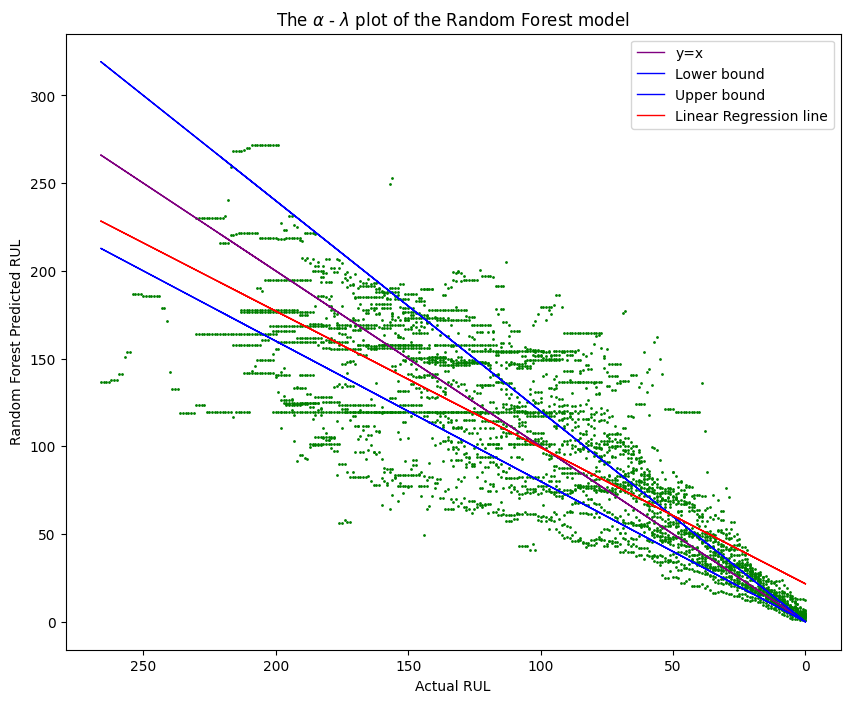

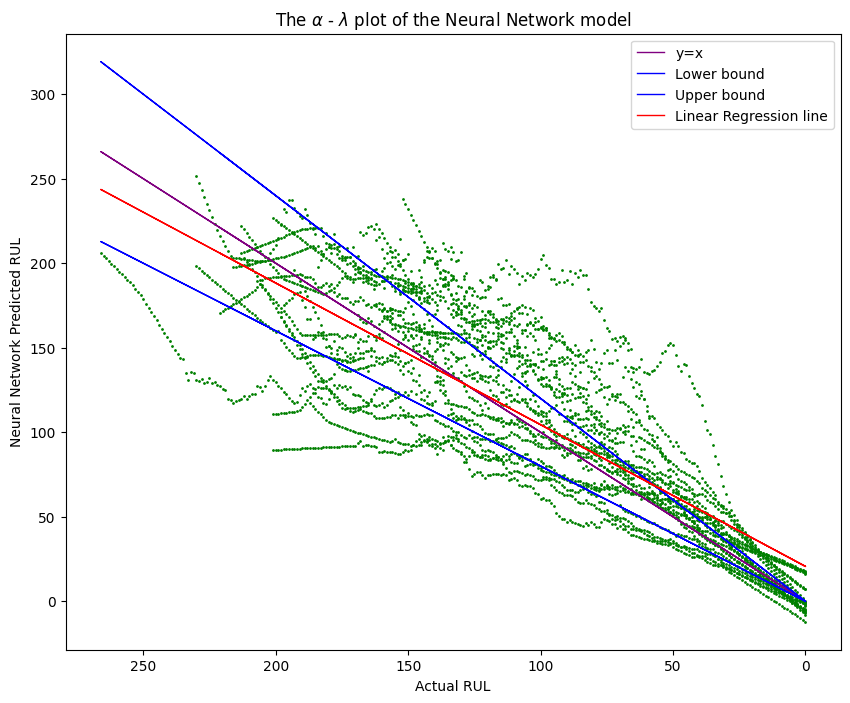

MAE Kalman: 26.042


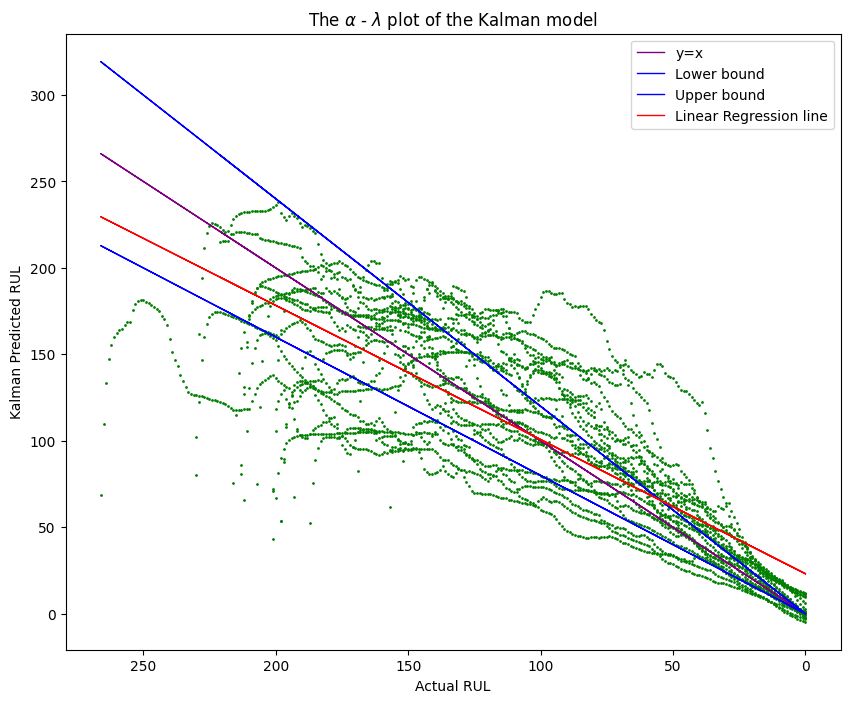

In [9]:
def main():
    CCMAPS_dataset = 'les05_CMAPSStrain001.txt'
    CCMAPS_dataset_RUL = 'RUL_FD001.csv'

    original_dataset = read_in_and_process_data(CCMAPS_dataset, toggle_plot=False)

    dataset = read_in_and_process_data(CCMAPS_dataset, toggle_plot=False)
    dataset, explained_variance_ratio = PCA_transformation(dataset, n_last_columns=24, n_components=6)
    dataset = add_rul_to_transformed(original_dataset, dataset)
    dataset, scaler = scale_data(dataset, feature_range=(0, 1))
    y_test_pred_rfr, y_test_pred_nn, test_y, rfr_score_list, mae_rfr_list, nn_score_list, mae_nn_list = evaluate_models(dataset, dataset['Equipment'].unique(), n_train=80, random_state=0, depth=10, n_estimators=10)

    # Calculate the performance metrics for the predictions
    # rfr_metrics = calculate_performance_metrics(y_test_pred_rfr, dataset['RUL'])
    # nn_metrics = calculate_performance_metrics(y_test_pred_nn, dataset['RUL'])
    

    #plotting
    # print(test_y, len(y_test_pred_rfr), len(y_test_pred_nn))
    plot_predictions_vs_actual(test_y, y_test_pred_rfr, 'Random Forest', 0.2)
    plot_predictions_vs_actual(test_y, y_test_pred_nn, 'Neural Network', 0.2)


    #Kalman
    kalman_joint, mae_kalman = kalman_filter(y_test_pred_rfr, y_test_pred_nn, test_y, q=12)
    print('MAE Kalman: %.3f' % mae_kalman)
    plot_predictions_vs_actual(test_y, kalman_joint, 'Kalman', 0.2)

if __name__ == "__main__":
    main()